# Survival Analysis Tutorial Part 1

[I. What is time-censored data?](#I.-What-is-time-censored-data?) <br>
[II. Single event survival analysis with Kaplan-Meier](#II.-Single-event-survival-analysis-with-Kaplan-Meier) <br>
[III. Competing risks modeling with Nelson Aalen and Aalen Johansen](#III.-Competing-risks-modeling-with-Nelson-Aalen-and-Aalen-Johansen) <br>
[IV. Calibration using the integrated brier score (IBS)](#IV.-Calibration-using-the-integrated-brier-score-(IBS)) <br>
[V. Predictive survival analysis modeling](V.-Predictive-survival-analysis-modeling) <br>
[VI. Competitive risk using our GradientBoostedIBS model](#VI.-Competitive-risk-using-our-GradientBoostedIBS-model) <br>

## I. What is time-censored data?

### I.1 Censoring

Survival analysis is a time-to-event regression problem, with censored data. We call censored all individuals that didn't experience the event during the range of the observation window.

In our setting, we're mostly interested in right-censored data, meaning we either lost track of the individual, or the study ended before the event of the individual could be observed.

<figure>
<img src="censoring.png" style="width:80%">
<figcaption align = "center"> <i>image credit: scikit-survival</i> </figcaption>
</figure>

Individuals can join the study at the same or different times, and the study may or may not be ended by the time of observation.

Survival analysis techniques have wide applications. In the medical landscape, events can consist in patients dying of cancer, or on the contrary recovering from some disease. In predictive maintenance, events can model machine failure. In marketing, we can consider user churning as events, or we could focus on users becoming premium.


### I.2 Our target `y`

For each individual $i\in[1, N]$, our survival analysis target $y_i$ is comprised of two elements:

- The event $\delta_i\in\{0, 1\}$, where $0$ is censoring and $1$ is experiencing the event.
- The censored time-to-event $d_i=min(t_{i}, c_i) > 0$, that is the minimum between the date of the experienced event $t_i$ and the censoring date $c_i$. In a real-world setting, we don't have direct access to $t_i$ when $\delta_i=0$.

Here is how we represent our target:

In [57]:
import pandas as pd

df = pd.read_parquet("data_truck_no_covariates.parquet")
df[["event", "duration"]].head()

,event,duration
0,True,138.0
1,False,2639.6
2,True,983.0
3,True,207.0
4,False,2639.6


In this exemple, we study the accident of truck-driver pairs. Censored pairs (when event is False) haven't had a mechanical failure or an accident during the study.

### I.3 Why is it a problem to train time-to-event regression models?

Without survival analysis, we have two options when confronting censored data:
- We ignore them, by only keeping events that happened and performing naive regression on them.
- We consider that all censored events happen at the end of our observation window.

**Both approaches are wrong and lead to biased results.**

Let's compute the average duration yielded by both approaches on our truck dataset. We will compare them to the mean of the ground-truth event time $T$, that we would obtained with an infinite observation window. 

Note that we have access to the random variable $T$ because we generated this synthetic dataset. With real-world data, you only have access to $Y = \min(T, C)$, where $C$ is a random variable representing the censoring time.

In [63]:
stats_1 = (
    df.loc[df["event"]]["duration"]
    .apply(["mean", "median"])
)
print(
    f"Biased method 1 - mean: {stats_1['mean']:.2f} days, "
    f"median: {stats_1['median']:.2f} days"
)

Biased method 1 - mean: 725.13 days, median: 286.00 days


In [62]:
import numpy as np

max_duration = df["duration"].max()
stats_2 = (
    pd.Series(
        np.where(df["event"], df["duration"], max_duration)
    )
    .apply(["mean", "median"])
)
print(
    f"Biased method 2 - mean: {stats_2['mean']:.2f} days, "
    f"median: {stats_2['median']:.2f} days"
)

Biased method 2 - mean: 1299.47 days, median: 1021.50 days


In [60]:
true_stats = df["ground_truth_duration"].apply(["mean", "median"])
print(
    f"Ground truth - mean: {true_stats['mean']:.2f} days, "
    f"median: {true_stats['median']:.2f} days"
)

Ground truth - mean: 1417.37 days, median: 1021.50 days


In [ ]:
true_stats = df["ground_truth_duration"].apply(["mean"])
print(f"Ground truth: {true_stats['mean']:.2f} days")

We see that none of this naive methods gives a good estimate of the ground truth. A naive regression would try to estimate $\mathbb{E}[T|X]$, where $X$ are our covariates, but we only have access to $Y = \min(T, C)$.

## II. Single event survival analysis with Kaplan Meier

We now introduce the survival analysis approach to the problem of estimating the time-to-event from censored data. For now, we ignore any information from $X$ and focus on $y$ only.

Here our quantity of interest is the survival probability:

$$S(t)=P(T > t)$$ 

This represents the probability that an event doesn't occur at or before some given time $t$, i.e. that it happens at some time $T > t$.

The most commonly used method to estimate this function is the **Kaplan Meier** estimator. It gives us an unbiased estimate of the survival probability, ignoring any information available in $X$.

$$\hat{S}(t)=\prod_{i: t_i\leq t} (1 - \frac{d_i}{n_i})$$

Where $t_i$ is the time of event for individual $i$ that experienced the event, $d_i$ is the number of individuals having experienced the event at $t_i$, and $n_i$ are the remaining individuals at risk at $t_i$. Note that individuals that were censored before $t_i$ are no longer considered at risk at $t_i$.

In real-world application, we aim at estimating $\mathbb{E}[T]$ or $Q_{50\%}[T]$. The latter quantity represents the median survival duration i.e. the duration before 50% of our population at risk experiment the event. We can also be interested in estimating the survival probability after some reference time $P(T > t_{ref})$, e.g. a random clinical trial estimating the capacity of a drug to improve the survival probability after 6 months.

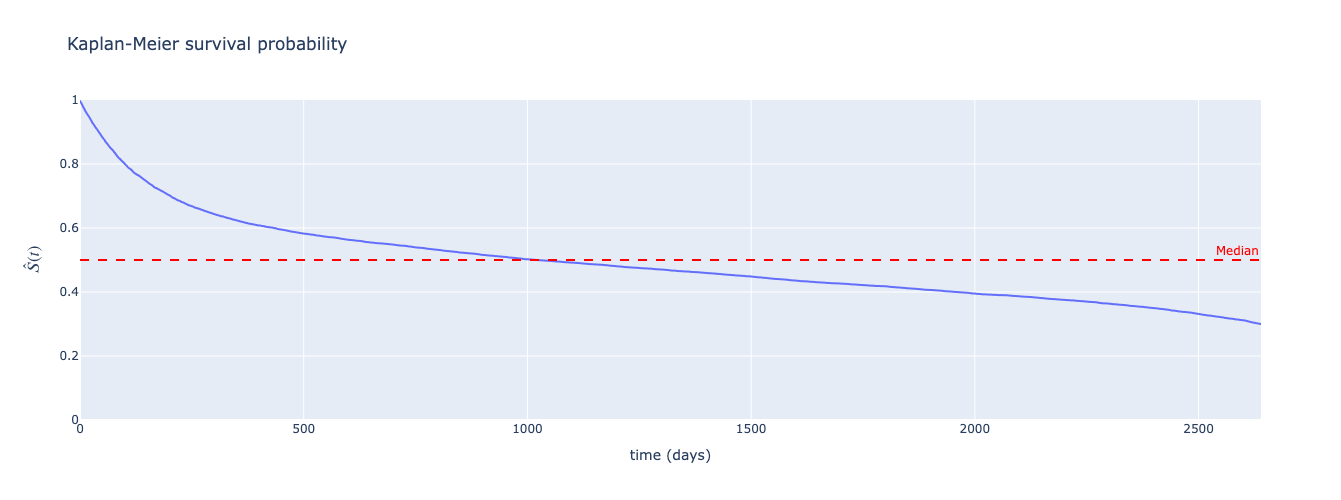

In [52]:
import plotly.express as px
from sksurv.nonparametric import kaplan_meier_estimator


times, survival_probas = kaplan_meier_estimator(df["event"], df["duration"])

km_proba = pd.DataFrame(dict(time=times, survival_proba=survival_probas))
fig = px.line(
    km_proba,
    x="time",
    y="survival_proba",
    title="Kaplan-Meier survival probability",
)
fig.add_hline(
    y=0.50,
    annotation_text="Median",
    line_dash="dash",
    line_color="red",
    annotation_font_color="red",
)

fig.update_layout(
    height=500,
    width=800,
    xaxis_title="time (days)",
    yaxis_title="$\hat{S}(t)$",
    yaxis_range=[0, 1],
)

We can read the median time to event directly from this curve, in this case close to 1020 days.
Note that since we have censored data, $S(t)$ doesn't reach 0 within our observation window and we have residuals of 30%.

***Exercice*** <br>
Based on `times` and `survival_proba`, estimate the median survival time.
*Hint: Use `np.searchsorted`*.

In [7]:
def get_median_survival_proba(times, survival_proba):
    """Get the closest time to a survival proba of 50%.
    """
    ### Your code here
    median_survival_proba_time = 0
    ###
    return median_survival_proba_time

In [8]:
get_median_survival_proba(times, survival_probas)

0

<details><summary><i><b>Solution</b></i></summary>
<br>
    
```python
def get_median_survival_proba(times, survival_proba):
    """Get the closest time to a survival proba of 50%.
    """
    # Search sorted needs an ascending ordered array.
    sorted_survival_proba = survival_proba[::-1]
    median_idx = np.searchsorted(sorted_survival_proba, 0.50)
    median_survival_proba_time = times[-median_idx]
    return median_survival_proba_time
```
    
</details>

We can enrich our analysis by introducing covariates, that are statistically associated to the events and durations.

In [105]:
df = pd.read_parquet("data_truck.parquet")
df["event"] = df["event"] > 0
df

,driver_skills,brand,model_id,usage_rate,duration,event
0,1.0,Robusta,Model 5,0.766315,31,True
1,0.5,Cheapz,Model 4,0.783321,2020,True
2,0.5,Cheapz,Model 5,0.748335,2052,True
3,0.5,Robusta,Model 2,0.688632,3389,True
4,0.8,Robusta,Model 3,0.514078,3256,True
...,...,...,...,...,...,...
9995,1.0,Robusta,Model 4,0.867071,2628,True
9996,1.0,Robusta,Model 5,0.790647,2885,True
9997,1.0,Cheapz,Model 5,0.523682,2825,True
9998,1.0,Cheapz,Model 2,0.384571,3650,False


For exemple, let's use Kaplan Meier to get a sense of the impact of the **brand**, by stratifying on this variable.

***Exercice*** <br>
Plot the stratified Kaplan Meier of the brand, i.e. for each different brand:
1. Filter the dataset on this brand
2. Estimate the survival probability with Kaplan Meier
3. Subplot this survival probability.

What are the limits of this method?

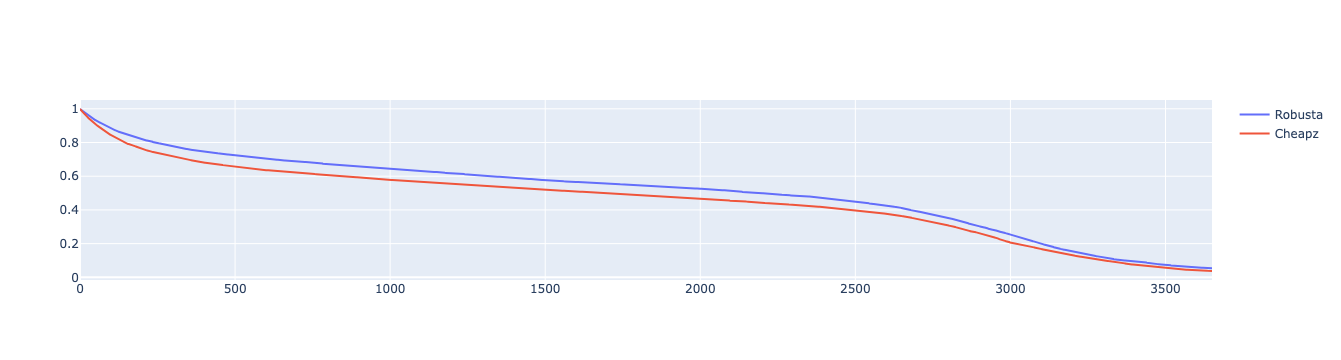

In [106]:
brands = df["brand"].unique()
fig_data = []
for brand in brands:
    df_brand = df.loc[df["brand"] == brand]
    times_, survival_probas_ = kaplan_meier_estimator(df_brand["event"], df_brand["duration"])
    fig_data.append(
        go.Scatter(x=times_, y=survival_probas_, name=brand)
    )
go.Figure(fig_data)

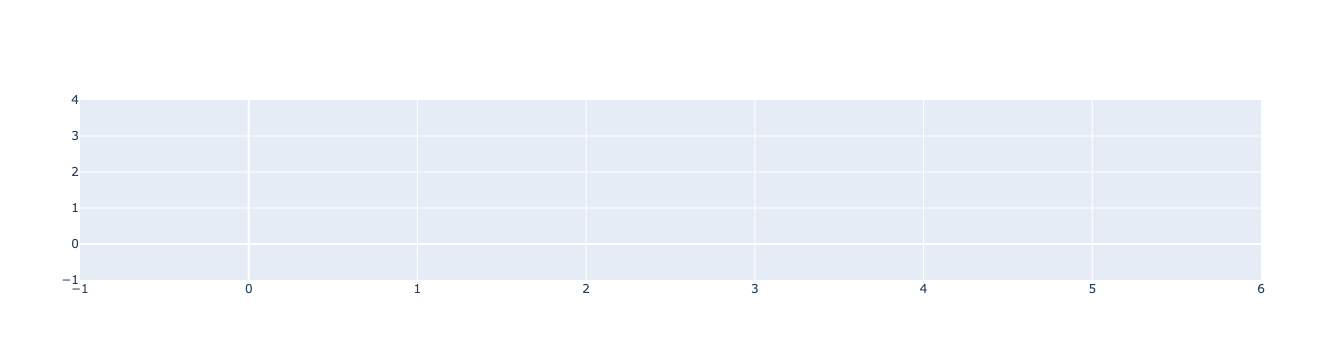

In [107]:
import plotly.graph_objects as go


brands = df["brand"].unique()
fig_data = []
for brand in brands:
    ### Your code here
    pass
    ###
go.Figure(fig_data)

<details><summary><i><b>Solution</b></i></summary>
<br>
    
```python
import plotly.graph_objects as go

brands = df["brand"].unique()
fig_data = []
for brand in brands:
    df_brand = df.loc[df["brand"] == brand]
    times_, survival_probas_ = kaplan_meier_estimator(df_brand["event"], df_brand["duration"])
    fig_data.append(
        go.Scatter(x=times_, y=survival_probas_, name=brand)
    )
go.Figure(fig_data)
```

<br>
The stratified method quickly become impracticable as the covariate groups grow. We need estimator that can handle covariates.
    
</details>

Next, we'll study how to add covariates $X$ to our analysis. To do so, we need to introduce our main metric. $S(t)$

## III. Calibration using the integrated brier score (IBS)

The Brier score is a proper scoring rule that measures the calibration of our survival probability predictions. It is comprised between 0 and 1 (lower is better).
It answers the question "how close to the real probabilities are our estimates?". A good calibration makes our predictions easier to explain.

<details><summary>Mathematical formulation</summary>
    
$$\mathrm{BS}^c(t) = \frac{1}{n} \sum_{i=1}^n I(d_i \leq t \land \delta_i = 1)
        \frac{(0 - \hat{S}(t | \mathbf{x}_i))^2}{\hat{G}(d_i)} + I(d_i > t)
        \frac{(1 - \hat{S}(t | \mathbf{x}_i))^2}{\hat{G}(t)}$$
    
In the survival analysis context, the Brier Score can be seen as the Mean Squared Error (MSE) between our probability $\hat{S}(t)$ and our target label $\delta_i \in {0, 1}$, weighted by the inverse probability of censoring $\frac{1}{\hat{G}(t)}$.
- When no event or censoring has happened at $t$ yet, i.e. $I(d_i > t)$, we penalize a low probability of survival with $(1 - \hat{S}(t|\mathbf{x}_i))^2$.
- Conversely, when an individual has experienced an event before $t$, i.e. $I(d_i \leq t \land \delta_i = 1)$, we penalize a high probability of survival with $(0 - \hat{S}(t|\mathbf{x}_i))^2$.
    
<figure>
<img src="BrierScore.svg" style="width:80%">
</figure>
    
</details>

In [110]:
times, survival_proba = kaplan_meier_estimator(df["event"], df["duration"])

In [111]:
def make_target(event, duration):
    """Return scikit-survival's specific target format.
    """
    y = np.empty(
        shape=event.shape[0],
        dtype=[("event", bool), ("duration", float)],
    )
    y["event"] = event
    y["duration"] = duration
    
    return y

In [112]:
from sksurv.metrics import brier_score
from sksurv.functions import StepFunction

# Create a callable function from times and survival proba.
survival_func = StepFunction(times, survival_proba)

# Bound `times` to the range of `duration`.
# This is needed to compute the brier score.
times = np.linspace(
    df["duration"].min(),
    df["duration"].max() - 1,
    num=100,
)

# Call the function with the new `times` variable and
# get the matching survival proba.
survival_proba = survival_func(times)

# Stack `N` survival proba vectors to simulate predictions
# for all individuals.
n_samples = len(event)
km_survival_proba_matrix = np.vstack([survival_proba] * n_samples)

# Adapt the event and duration to scikit-survival specific
# numpy array target.
y = make_target(df["event"], df["duration"])

_, km_brier_scores = brier_score(
    survival_train=y,
    survival_test=y,
    estimate=km_survival_proba_matrix,
    times=times,
)

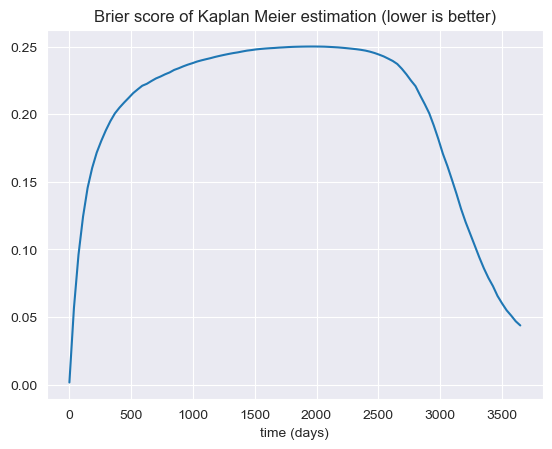

In [113]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")

plt.plot(times, km_brier_scores);
plt.title("Brier score of Kaplan Meier estimation (lower is better)");
plt.xlabel("time (days)");

Additionnaly, we compute the Integrated Brier Score (IBS) which we will use to rank estimators:
$$IBS = \frac{1}{t_{max} - t_{min}}\int^{t_{max}}_{t_{min}} BS(t) dt$$

In [114]:
integrated_brier_score(
    survival_train=y,
    survival_test=y,
    estimate=km_survival_proba_matrix,
    times=times,
)

0.20251303661616163

Finally, let's also introduce the concordance index (C-index). This metric evaluates the discriminative power of a model by comparing pairs of individuals having experienced the event. The C-index of a pair $(i, j)$ is maximized when individual $i$ has experienced the event before $j$ and the estimated risk of $i$ is higher than the one of $j$. 

This metric is also comprised between 0 and 1 (higher is better), 0.5 corresponds to a random prediction.

<details><summary>Mathematical formulation</summary>
    
$$\mathrm{C_{index}} = \frac{\sum_{i,j} I(d_i \leq t \space \land \space \delta_i = 1 \space \land \space \mu_i < \mu_j)}{\sum_{i,j} I(d_i \leq t \space \land \space \delta_i = 1)}$$

The risk $\mu_i$ can be computed as the integral of the cumulative incidence function (CIF):

$$\int^{t_{max}}_{t_{min}} F(t|x_i) dt = \int^{t_{max}}_{t_{min}} 1 - S(t|x_i) dt$$
    
</details>

To compute the C-index of our Kaplan Meier estimates, we assign every individual with the same survival probabilities given by the Kaplan Meier.

In [115]:
from sksurv.metrics import concordance_index_censored


def get_c_index(event, duration, survival_proba_matrix):
    if survival_proba_matrix.ndim != 2:
        raise ValueError(
            "`survival_probas` must be a 2d array of "
            "shape (n_samples, times)."
        )
    # Cumulative hazard is also known as risk.
    cumulative_hazard = survival_to_risk_estimate(survival_proba_matrix)
    metrics = concordance_index_censored(event, duration, cumulative_hazard)
    return metrics[0]


def survival_to_risk_estimate(survival_proba_matrix):
    return -np.log(survival_proba_matrix + 1e-8).sum(axis=1)

In [139]:
km_c_index = get_c_index(df["event"], df["duration"], km_survival_proba_matrix)
km_c_index

0.5

This is equivalent to a random prediction. Indeed, as our Kaplan Meier is a descriptive statistics, it can't be used to rank individuals predictions.

## IV. Predictive survival analysis

We now introduce some quantities which are going to be at the core of our predictions.

The most important concept is the hazard rate $\lambda(t)$. This quantity represents the "speed of failure" or the probability that an event occurs in the next $dt$, given that it hasn't occured yet. This can be written as:

$$\begin{align}
\lambda(t) &=\lim_{dt\rightarrow 0}\frac{P(t \leq T < t + dt | P(T \geq t))}{dt} \\
&= \lim_{dt\rightarrow 0}\frac{P(t \leq T < t + dt)}{dtS(t)} \\
&= \frac{f(t)}{S(t)}
\end{align}
$$

where $f(t)$ represents the probability density. This quantity estimates the probability that an event occurs in the next $dt$, independently of this event having happened before. <br>
If we integrate $f(t)$, we found the cumulative incidence function (CIF) $F(t)=P(T < t)$, which is the opposite of the survival function $S(t)$:

$$F(t)=\int^\infty_0f(t)dt=1-S(t)$$

### IV.1 Cox Proportional Hazards

The Cox PH model is the canonical way of dealing with covariates $X$ in survival analysis. It computes a log linear regression on the target $Y = \min(T, C)$, and consists in a baseline term $\lambda_0(t)$ and a covariate term with weights $\beta$.
$$\lambda(t, x_i) = \lambda_0(t) \exp(x_i^\top \beta)$$

Note that here only the baseline depends on time, but we can extend Cox PH to time-dependent covariate $x_i(t)$ and time-dependent weigths $\beta(t)$. We won't cover these extensions in this tutorial.

It is called ***proportional*** hazards, since for two different covariate vectors $x_i$ and $x_j$, their ratio is:
$$\frac{\lambda(t, x_i)}{\lambda(t, x_j)} = \frac{\lambda_0(t) e^{x_i^\top \beta}}{\lambda_0(t) e^{x_j^\top \beta}}=\frac{e^{x_i^\top \beta}}{e^{x_j^\top \beta}}$$

This ratio is not dependent on time, and therefore the hazards are proportional.

Let's run it on our truck-driver dataset.

In [116]:
df

,driver_skills,brand,model_id,usage_rate,duration,event
0,1.0,Robusta,Model 5,0.766315,31,True
1,0.5,Cheapz,Model 4,0.783321,2020,True
2,0.5,Cheapz,Model 5,0.748335,2052,True
3,0.5,Robusta,Model 2,0.688632,3389,True
4,0.8,Robusta,Model 3,0.514078,3256,True
...,...,...,...,...,...,...
9995,1.0,Robusta,Model 4,0.867071,2628,True
9996,1.0,Robusta,Model 5,0.790647,2885,True
9997,1.0,Cheapz,Model 5,0.523682,2825,True
9998,1.0,Cheapz,Model 2,0.384571,3650,False


In [117]:
duration = df.pop("duration")
event = df.pop("event")
y = make_target(event, duration)
X = df

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((7500, 4), (2500, 4))

***Exercice***

Create a `ColumnTransformer` to encode categories `brand` and `model_id`.

*Hint*: Use `sklearn.preprocessing.OneHotEncoder` and `sklearn.compose.make_column_transformer`.

In [ ]:
### your code here
transformer = None
###

In [119]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

transformer = make_column_transformer(
    (OneHotEncoder(), ["brand", "model_id"]),
    remainder="passthrough",
)

<details><summary><b><i>Solution</i></b></summary>
<br>

```python
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

transformer = make_column_transformer(
    (OneHotEncoder(), ["brand", "model_id"]),
    remainder="passthrough",
)
```
</details>

In [120]:
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis

cox_ph = make_pipeline(
    transformer,
    CoxPHSurvivalAnalysis(alpha=1e-4)
)
cox_ph.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['brand', 'model_id'])])),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis(alpha=0.0001))])

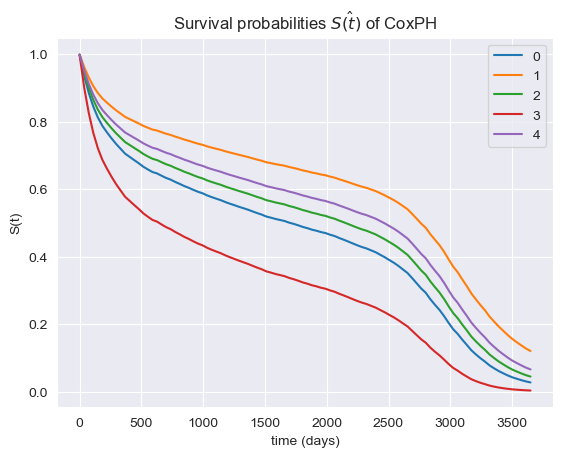

In [121]:
step_funcs = cox_ph.predict_survival_function(X_test)

fig, ax = plt.subplots()
for idx, step_func in enumerate(step_funcs[:5]):
    survival_proba = step_func(times)
    ax.plot(times, survival_proba, label=idx)
ax.set(
    title="Survival probabilities $\hat{S(t)}$ of CoxPH",
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend();

In [122]:
df.head()

,driver_skills,brand,model_id,usage_rate
0,1.0,Robusta,Model 5,0.766315
1,0.5,Cheapz,Model 4,0.783321
2,0.5,Cheapz,Model 5,0.748335
3,0.5,Robusta,Model 2,0.688632
4,0.8,Robusta,Model 3,0.514078


We see that we can get some intuition about the features importance from the first 5 truck-driver pairs and their survival probabilities.

***Exercice***

Plot the feature importance $\beta$ of the model (stored under `_coef`) with their names from the `get_feature_names_out()` method of the transformer.

*Hint*: You can access an element of a pipeline as simply as `pipeline[idx]`.

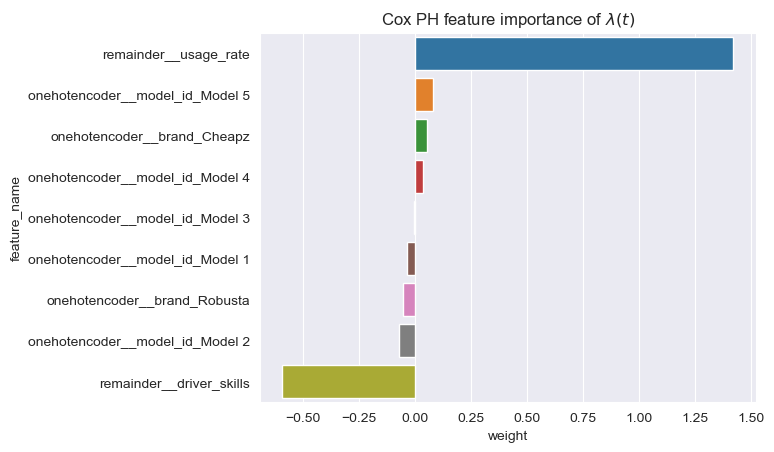

In [123]:
feature_names = cox_ph[0].get_feature_names_out()
weights = cox_ph[-1].coef_

features = (
    pd.DataFrame(dict(
        feature_name=feature_names,
        weight=weights,
    ))
    .sort_values("weight", ascending=False)
)
ax = sns.barplot(features, y="feature_name", x="weight", orient="h")
ax.set_title("Cox PH feature importance of $\lambda(t)$");

In [ ]:
### Your code here
features_names = []
weight = []
###

feature = pd.DataFrame(
    feature_name=feature_names,
    weigth=weigth
)
ax = sns.barplot(features, y="feature_name", x="weight", orient="h")

<details><summary><i><b>Solution</b></i></summary>
<br>

```python
feature_names = cox_ph[0].get_feature_names_out()
weights = cox_ph[-1].coef_

features = (
    pd.DataFrame(dict(
        feature_name=feature_names,
        weight=weights,
    ))
    .sort_values("weight", ascending=False)
)
ax = sns.barplot(features, y="feature_name", x="weight", orient="h")
ax.set_title("Cox PH feature importance of $\lambda(t)$");
```

</details>

Finally, we compute the Brier score for our model.

CoxPH IBS: 0.1982
KaplanMeier IBS: 0.2025


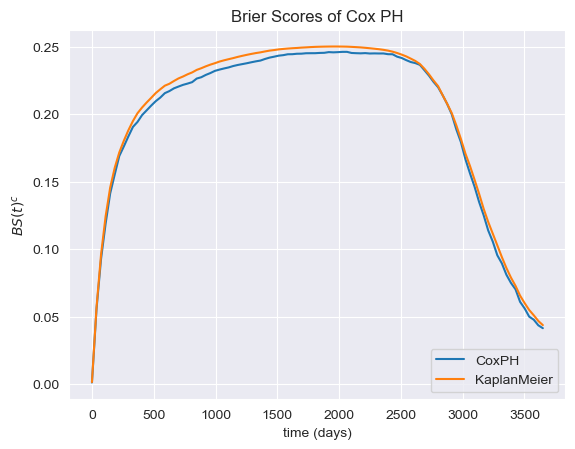

In [124]:
from sksurv.metrics import brier_score, integrated_brier_score

cox_survival_proba_matrix = np.vstack([step_func(times) for step_func in step_funcs])

_, cox_brier_scores = brier_score(
    survival_train=y_train,
    survival_test=y_test,
    estimate=cox_survival_proba_matrix,
    times=times,
)

cox_ibs = integrated_brier_score(
    survival_train=y_train,
    survival_test=y_test,
    estimate=cox_survival_proba_matrix,
    times=times,
)

fig, ax = plt.subplots()
ax.plot(times, cox_brier_scores, label="CoxPH")
ax.plot(times, km_brier_scores, label="KaplanMeier")
ax.set(
    title="Brier Scores of Cox PH",
    xlabel="time (days)",
    ylabel="$BS(t)^c$",
)
plt.legend();

print(f"KaplanMeier IBS: {km_ibs:.4f}")
print(f"CoxPH IBS: {cox_ibs:.4f}")

In [140]:
cox_c_index = get_c_index(y_test["event"], y_test["duration"], cox_survival_proba_matrix)

print(f"Kaplan Meier C-index: {km_c_index:.4f}")
print(f"Cox PH C-index: {cox_c_index:.4f}")

Kaplan Meier C-index: 0.5000
Cox PH C-index: 0.5594


We have slightly improved upon the Kaplan Meier.

### IV.2 Random Survival Forest

In [127]:
from sksurv.ensemble import RandomSurvivalForest

rsf = make_pipeline(
    transformer,
    RandomSurvivalForest(n_estimators=10, max_depth=4, n_jobs=-1),
)
rsf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['brand', 'model_id'])])),
                ('randomsurvivalforest',
                 RandomSurvivalForest(max_depth=4, n_estimators=10,
                                      n_jobs=-1))])

In [128]:
times_chunked = times.copy()
times_chunked[-1] -= 1

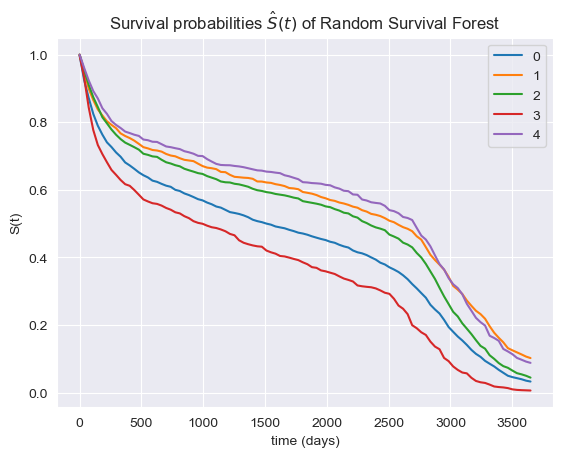

In [129]:
step_funcs = rsf.predict_survival_function(X_test)

fig, ax = plt.subplots()
for idx, step_func in enumerate(step_funcs[:5]):
    survival_proba = step_func(times_chunked)
    ax.plot(times_chunked, survival_proba, label=idx)
ax.set(
    title="Survival probabilities $\hat{S}(t)$ of Random Survival Forest",
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend();

KaplanMeier IBS: 0.2025
CoxPH IBS: 0.1982
RandomSurvivalForest IBS: 0.1971


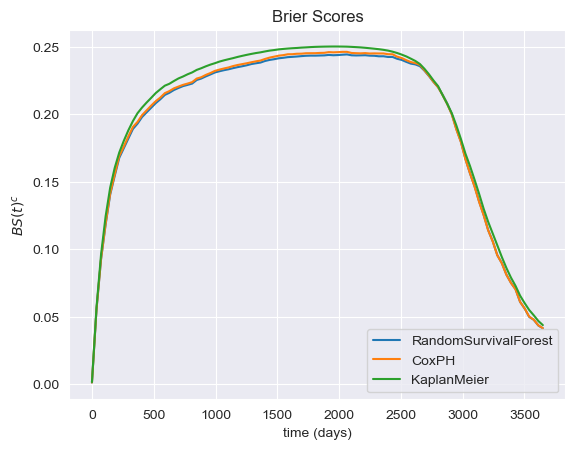

In [141]:
rsf_survival_proba_matrix = np.vstack([step_func(times_chunked) for step_func in step_funcs])

_, rsf_brier_scores = brier_score(
    survival_train=y_train,
    survival_test=y_test,
    estimate=rsf_survival_proba_matrix,
    times=times,
)

rsf_ibs = integrated_brier_score(
    survival_train=y_train,
    survival_test=y_test,
    estimate=rsf_survival_proba_matrix,
    times=times,
)

fig, ax = plt.subplots()
ax.plot(times, rsf_brier_scores, label="RandomSurvivalForest")
ax.plot(times, cox_brier_scores, label="CoxPH")
ax.plot(times, km_brier_scores, label="KaplanMeier")
ax.set(
    title="Brier Scores",
    xlabel="time (days)",
    ylabel="$BS(t)^c$",
)
plt.legend();

print(f"KaplanMeier IBS: {km_ibs:.4f}")
print(f"CoxPH IBS: {cox_ibs:.4f}")
print(f"RandomSurvivalForest IBS: {rsf_ibs:.4f}")

In [143]:
rsf_c_index = get_c_index(y_test["event"], y_test["duration"], rsf_survival_proba_matrix)

print(f"Kaplan Meier C-index: {km_c_index:.4f}")
print(f"Cox PH C-index: {cox_c_index:.4f}")
print(f"Random Survival Index C-index: {rsf_c_index:.4f}")

Kaplan Meier C-index: 0.5000
Cox PH C-index: 0.5594
Random Survival Index C-index: 0.5592


### IV.3 GradientBoostedIBS

In [42]:
import sys; sys.path.append("..")
from models.yasgbt import YASGBTRegressor
from model_selection.wrappers import PipelineWrapper

gb_model = make_pipeline(
    transformer,
    YASGBTRegressor(max_depth=5),
)
gb_model = PipelineWrapper(gb_model)
gb_model.fit(X_train, y_train, times)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.86it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 359.38it/s]


GradientBoostedIBS IBS: 0.2034
RandomSurvivalForest IBS: 0.1978
CoxPH IBS: 0.1986
KaplanMeier IBS: 0.2025


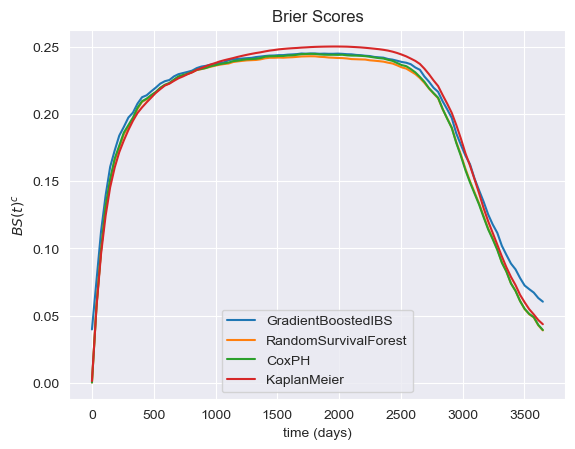

In [43]:
survival_proba_matrix = gb_model.predict_survival_function(X_test, times)

_, gb_model_brier_scores = brier_score(
    survival_train=y_train,
    survival_test=y_test,
    estimate=survival_proba_matrix,
    times=times,
)

gb_model_ibs = integrated_brier_score(
    survival_train=y_train,
    survival_test=y_test,
    estimate=survival_proba_matrix,
    times=times,
)

fig, ax = plt.subplots()
ax.plot(times, gb_model_brier_scores, label="GradientBoostedIBS")
ax.plot(times, rsf_brier_scores, label="RandomSurvivalForest")
ax.plot(times, cox_brier_scores, label="CoxPH")
ax.plot(times, km_brier_scores, label="KaplanMeier")
ax.set(
    title="Brier Scores",
    xlabel="time (days)",
    ylabel="$BS(t)^c$",
)
plt.legend();

print(f"GradientBoostedIBS IBS: {gb_model_ibs:.4f}")
print(f"RandomSurvivalForest IBS: {rsf_ibs:.4f}")
print(f"CoxPH IBS: {cox_ibs:.4f}")
print(f"KaplanMeier IBS: {km_ibs:.4f}")

In [ ]:
survival_proba_matrix = gb_ibs.predict_survival_function()

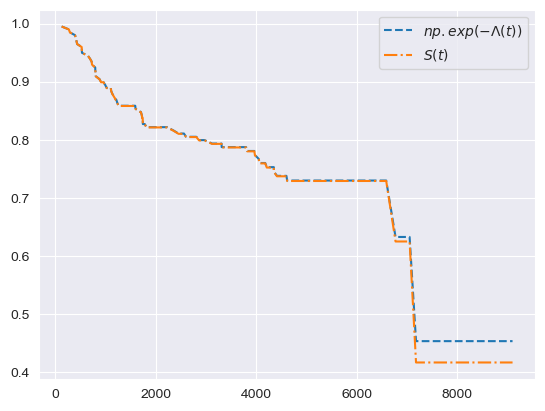

In [234]:
fig, ax = plt.subplots()
ax.plot(
    times,
    np.exp(-cumulative_hazard),
    label="$np.exp(-\hat{\Lambda}(t))$",
    linestyle="--",
);
ax.plot(
    times,
    survival_proba,
    label="$\hat{S}(t)$",
    linestyle="-.",
)
ax.set(
    title="Survival probability",
    xlabel="time (days)"
)
plt.legend();

In [ ]:
## On peut réutiliser les quantités au dessus pour chaque event, sauf la survie cause spécifique qui n'a pas de sens.
## Ajouter la motivation

In [196]:
import pandas as pd

factory_df = pd.read_parquet("factory_dataset.parquet")
factory_df[["duration", "event"]]

,duration,event
0,45,2
1,357,2
2,118,2
3,613,3
4,27,2
...,...,...
9995,38,2
9996,730,0
9997,527,2
9998,220,2


/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


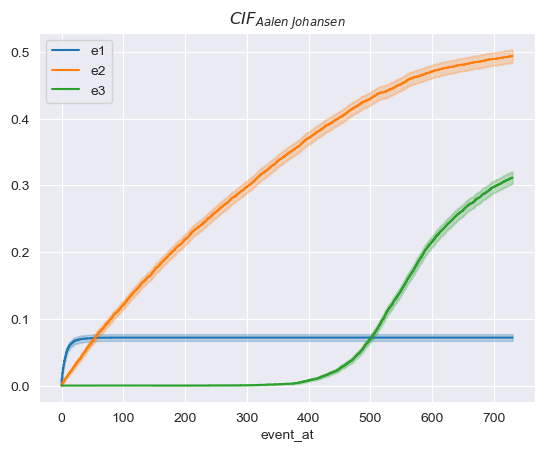

In [237]:
from lifelines import AalenJohansenFitter

for k in [1, 2, 3]:
    ajf = AalenJohansenFitter(calculate_variance=True)
    ajf.fit(factory_df["duration"], factory_df["event"], event_of_interest=k)
    ajf.plot(label=f"e{k}")
plt.title("$CIF_{Aalen\;Johansen}$");

We now illustrate that approximating the cause-specific survival function $S_k(t)$ by censoring all events that are different from $k$ and estimating the survival function $\hat{S}_k(t)$ leads to a upward bias of the incidence probability.

In other words, $\hat{S}_k(t) \neq S_k(t)$, when we build $\hat{S}_k(t)$ by censoring all events that are not $k$.

/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


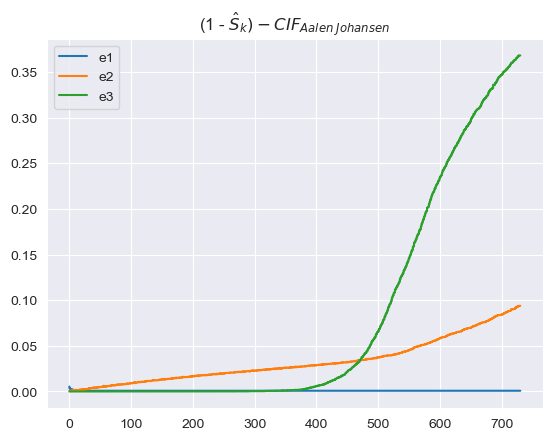

In [250]:
fig, ax = plt.subplots()

for k in [1, 2, 3]:
    times, survival_proba = kaplan_meier_estimator(
        factory_df["event"] == k,  # we censor all events != k
        factory_df["duration"],
    )
    
    ajf = AalenJohansenFitter(calculate_variance=True)        
    ajf.fit(factory_df["duration"], factory_df["event"], event_of_interest=k)
    
    # Select the times values of ajf that are the closest to
    # the kaplan meier times to compute their difference
    ajf_times = ajf.cumulative_density_.index
    idxs = np.searchsorted(ajf_times, times)
    ajf_cif = ajf.cumulative_density_.iloc[idxs].values.ravel()
    
    biased_cif = 1 - survival_proba
    cif_diff = biased_cif -  ajf_cif
    ax.step(times, cif_diff, label=f"e{k}")

plt.title("(1 - $\hat{S}_k) - CIF_{Aalen\;Johansen}$");
plt.legend();

Instead, we can derive the Aalen Johansen CIF from the cause-specific Nelson Aalen cumulative hazard $\Lambda_k(t)$, by computing the global survival probability $S(t)$, and applying equation:

$$F_k(t)=\int^t_0 \lambda_k(u)S(u)du$$

**// Can be completed as an exercice //**

In [247]:
def get_cif_from_cumulative_hazards(survival_proba, cumulative_hazard):
    hazard = np.diff(cumulative_hazard)
    event_density = hazard * survival_proba[1:]
    cif = event_density.cumsum()
    return cif

/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


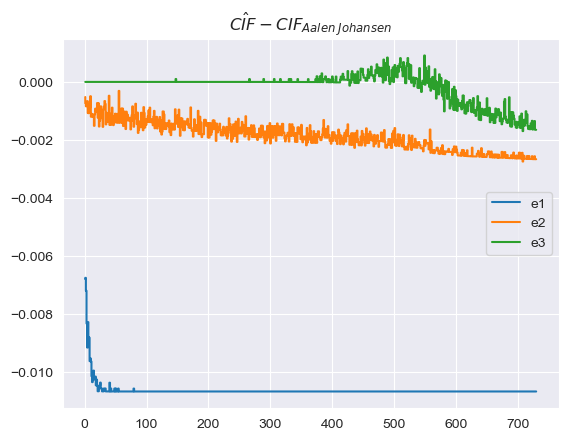

In [248]:
_, global_survival_proba = kaplan_meier_estimator(
    factory_df["event"] != 0,
    factory_df["duration"],
)

fig, ax = plt.subplots()
for k in [1, 2, 3]:
    times, cumulative_hazard = nelson_aalen_estimator(
        factory_df["event"] == k,  # we censor all events != k
        factory_df["duration"],
    )
    cif = get_cif_from_cumulative_hazards(global_survival_proba, cumulative_hazard)
    
    ajf = AalenJohansenFitter(calculate_variance=True)
    ajf.fit(factory_df["duration"], factory_df["event"], event_of_interest=k)
        
    # Select the times values of ajf that are the closest to
    # the nelson aalen times to compute their difference
    ajf_times = ajf.cumulative_density_.index
    idxs = np.searchsorted(ajf_times, times)
    ajf_cif = ajf.cumulative_density_.iloc[idxs].values.ravel()
    
    cif_diff = cif - ajf_cif[1:]
    ax.step(times[1:], cif_diff, label=f"e{k}")

plt.title("$\hat{CIF} - CIF_{Aalen\;Johansen}$");
plt.legend();

We see that the differences are small compared to using the cause specific survival function to compute the CIF.

## III. Competing risks modeling with Nelson-Aalen and Aalen Johansen

Real-world survival analysis problem often have multiple-events of interest whose probability are dependent. If these events are comparably represented, we need to estimate them jointly to avoid bias.

In our dataset, we have 3 types of failures..., someone in charge of ops would focus on this events, while supply manager will ...

### III.1 Nelson-Aalen

We now need to introduce new quantities:



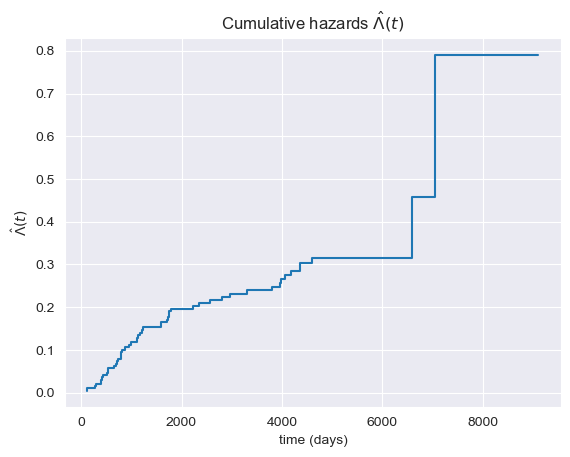

In [222]:
from sksurv.nonparametric import nelson_aalen_estimator

times, cumulative_hazard = nelson_aalen_estimator(y["event"], y["duration"])
fig, ax = plt.subplots()
ax.step(times, cumulative_hazard);
ax.set(
    title="Cumulative hazards $\hat{\Lambda}(t)$",
    xlabel="time (days)",
    ylabel="$\hat{\Lambda}(t)$",
);

### III.2 Aalen-Johanson


**Cumulative Incidence Function**

$\forall k \in [1, K]:$

$$F_k(t)=\int^t_0 \lambda_k(u)S(u)du = 1 - S_k(t)$$

where $\lambda_k$ is the cause-specific hazard for the event k, defined as:

$$\lambda_k(t)=\lim_{dt\rightarrow 0}\frac{P(t \leq T < t + dt, e=k)}{S(t)dt}$$

and $S_k(t)$ is the cause specific survival-function: 

$$S_k(t) = P(T > t, e=k)=e^{-\Lambda_k(t)}$$

which leads to:

$$S(t)=\prod_k S_k(t) = e^{-\sum_k \Lambda_k(t)}$$

**Aalen Johanson** estimates both the global survival function $\hat{S}(t)$ and the cause-specific hazard $\hat{\lambda_k}(t)$ to infer the CIF $\hat{F}_k(t)$:

$$\begin{align}
\hat{\lambda}_k(t_i)&=\frac{d_{k,i}}{n_i} \\
\hat{S}(t)&=\prod_{i:t_i\leq t} (1 - \frac{d_i}{n_i})=\prod_{i:t_i\leq t} (1 - \sum_k\hat{\lambda}_{k}(t_i))
\end{align}
$$

Then:

$$\hat{F}_k(t)=\sum_{i:t_i\leq t} \hat{\lambda}_k(t_i) \hat{S}(t_{i-1})$$


We will now use our factory dataset with competitive risk.

In [ ]:
## Créer un any-failure et un cause-specific dataset (renaming)
## Dans la vraie vie une usine avec 10k pannes est probablement problématique
## Nouvelle piste: Tous nos estimateurs se dégradent en baissant la taille du dataset, robustesse à la petite taille?
## Incertitudes plus proprement?

## V. Predictive survival analysis modeling

## VI. Competitive risk using our GradientBoostedIBS model

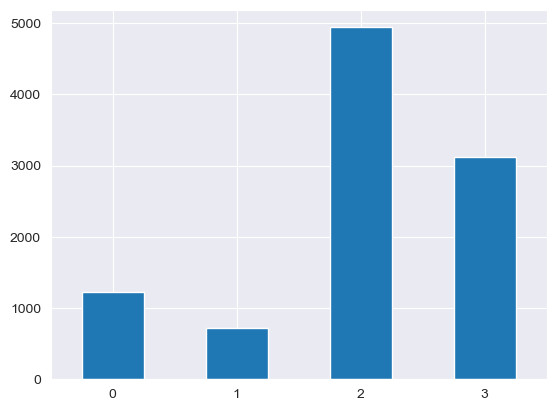

In [197]:
factory_df["event"].value_counts().sort_index().plot.bar(rot=0);

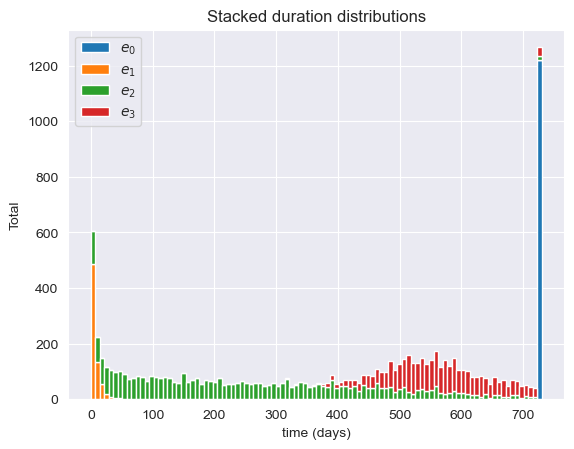

In [202]:
hists = [
    factory_df.loc[factory_df["event"] == event]["duration"]
    for event in range(4)
]
labels = [f"$e_{idx}$" for idx in range(4)]
fig, ax = plt.subplots()
ax.hist(hists, bins=100, stacked=True, label=labels);
ax.set(
    title="Stacked duration distributions",
    xlabel="time (days)",
    ylabel="Total",
)
plt.legend();

/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


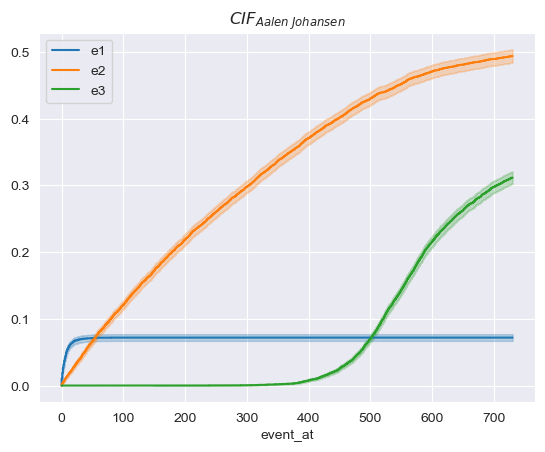

In [207]:
from lifelines import AalenJohansenFitter

for event_k in [1, 2, 3]:
    ajf = AalenJohansenFitter(calculate_variance=True)
    ajf.fit(factory_df["duration"], factory_df["event"], event_of_interest=event_k)
    ajf.plot(label=f"e{event_k}")
plt.title("$CIF_{Aalen\;Johansen}$");

In [ ]:
fig, ax = plt.subplots()
for event_k in [1, 2, 3]:
    times_k, survival_proba_k = kaplan_meier_estimator(
        factory_df["event"] == event_k,
        factory_df["duration"],
    )
    ax.step(km_x_, km_y_, label=f"e{event}")
plt.title("Kaplan Meier $\hat{S}(t)$");
plt.legend();

References

https://onlinelibrary.wiley.com/doi/epdf/10.1002/sim.2712

**Cumulative Hazard**

$$\Lambda(t)=\int^t_0 \lambda(u) du$$

Then:

$$S(t)=e^{-\Lambda(t)}$$


Like **Kaplan Meier** for the survival function, **Nelson Aalen** is an estimator of the cumulative hazard:

$$\hat{\Lambda}(t)=\sum_{i:t_i\leq t} \frac{d_i}{n_i}$$
